In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/RGB-img/img/"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/RGB-img/img/'

centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []

for file in files_all[:51]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[49:100]:
  right_files_path.append(folder_path + file)

In [7]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.25,fy=0.25, interpolation = cv2.INTER_CUBIC)
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 51/51 [01:36<00:00,  1.90s/it]


In [8]:
images_left_bgr_no_enhance = []
images_right_bgr_no_enhance = []


for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  left_img = cv2.resize(left_image_sat,None,fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
  images_left_bgr_no_enhance.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  right_img = cv2.resize(right_image_sat,None,fx=0.25,fy=0.25, interpolation = cv2.INTER_CUBIC)
  images_right_bgr_no_enhance.append(right_img)

100%|██████████| 51/51 [00:22<00:00,  2.31it/s]


In [9]:
surf  = cv2.xfeatures2d.SURF_create()
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for imgs in tqdm(images_left_bgr):
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 51/51 [03:54<00:00,  4.60s/it]


In [10]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [11]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.8,thresh=4,disp=False):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  #flann = cv2.BFMatcher()

  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])


  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print("\nNumber of matches",len(matches_lf1_lf))

  matches_4 = []
  ratio = ratio
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches After Lowe's Ratio",len(matches_4))
  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  
  Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  
  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  '''
  if len(inlier_matchset)<50:
    matches_4 = []
    ratio = 0.67
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
    '''
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [12]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [13]:
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1])
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1])
  H_right_surf.append(H_a)

  2%|▏         | 1/51 [00:02<01:48,  2.17s/it]


Number of matches 19474
Number of matches After Lowe's Ratio 1896
Number of Robust matches 821




  4%|▍         | 2/51 [00:04<01:44,  2.14s/it]


Number of matches 21329
Number of matches After Lowe's Ratio 2256
Number of Robust matches 1142




  6%|▌         | 3/51 [00:06<01:40,  2.09s/it]


Number of matches 17831
Number of matches After Lowe's Ratio 1690
Number of Robust matches 662




  8%|▊         | 4/51 [00:07<01:32,  1.97s/it]


Number of matches 18839
Number of matches After Lowe's Ratio 2458
Number of Robust matches 1315




 10%|▉         | 5/51 [00:09<01:27,  1.91s/it]


Number of matches 19367
Number of matches After Lowe's Ratio 2418
Number of Robust matches 1231




 12%|█▏        | 6/51 [00:11<01:25,  1.90s/it]


Number of matches 20181
Number of matches After Lowe's Ratio 2565
Number of Robust matches 1283




 14%|█▎        | 7/51 [00:13<01:25,  1.95s/it]


Number of matches 21645
Number of matches After Lowe's Ratio 3930
Number of Robust matches 2211




 16%|█▌        | 8/51 [00:15<01:25,  1.99s/it]


Number of matches 20323
Number of matches After Lowe's Ratio 3357
Number of Robust matches 2139




 18%|█▊        | 9/51 [00:17<01:24,  2.00s/it]


Number of matches 21322
Number of matches After Lowe's Ratio 3432
Number of Robust matches 2034




 20%|█▉        | 10/51 [00:19<01:22,  2.02s/it]


Number of matches 20509
Number of matches After Lowe's Ratio 3350
Number of Robust matches 2268




 22%|██▏       | 11/51 [00:21<01:23,  2.08s/it]


Number of matches 20626
Number of matches After Lowe's Ratio 3786
Number of Robust matches 2660




 24%|██▎       | 12/51 [00:24<01:20,  2.06s/it]


Number of matches 20175
Number of matches After Lowe's Ratio 4096
Number of Robust matches 2961




 25%|██▌       | 13/51 [00:25<01:17,  2.04s/it]


Number of matches 20342
Number of matches After Lowe's Ratio 3328
Number of Robust matches 2112




 27%|██▋       | 14/51 [00:27<01:15,  2.03s/it]


Number of matches 20114
Number of matches After Lowe's Ratio 2529
Number of Robust matches 1536




 29%|██▉       | 15/51 [00:30<01:14,  2.06s/it]


Number of matches 19707
Number of matches After Lowe's Ratio 3030
Number of Robust matches 1740




 31%|███▏      | 16/51 [00:32<01:11,  2.03s/it]


Number of matches 20830
Number of matches After Lowe's Ratio 2737
Number of Robust matches 1394




 33%|███▎      | 17/51 [00:34<01:09,  2.05s/it]


Number of matches 20628
Number of matches After Lowe's Ratio 2799
Number of Robust matches 1560




 35%|███▌      | 18/51 [00:36<01:07,  2.06s/it]


Number of matches 21000
Number of matches After Lowe's Ratio 1568
Number of Robust matches 680




 37%|███▋      | 19/51 [00:38<01:07,  2.11s/it]


Number of matches 20562
Number of matches After Lowe's Ratio 1901
Number of Robust matches 680




 39%|███▉      | 20/51 [00:40<01:04,  2.07s/it]


Number of matches 19134
Number of matches After Lowe's Ratio 2201
Number of Robust matches 1110




 41%|████      | 21/51 [00:42<01:01,  2.04s/it]


Number of matches 21352
Number of matches After Lowe's Ratio 2036
Number of Robust matches 716




 43%|████▎     | 22/51 [00:44<00:59,  2.04s/it]


Number of matches 19480
Number of matches After Lowe's Ratio 1303
Number of Robust matches 445




 45%|████▌     | 23/51 [00:46<00:55,  1.99s/it]


Number of matches 19951
Number of matches After Lowe's Ratio 2013
Number of Robust matches 873




 47%|████▋     | 24/51 [00:48<00:53,  2.00s/it]


Number of matches 19257
Number of matches After Lowe's Ratio 1185
Number of Robust matches 384




 49%|████▉     | 25/51 [00:50<00:50,  1.96s/it]


Number of matches 19012
Number of matches After Lowe's Ratio 948
Number of Robust matches 130




 51%|█████     | 26/51 [00:52<00:48,  1.95s/it]


Number of matches 19490
Number of matches After Lowe's Ratio 2423
Number of Robust matches 1200




 53%|█████▎    | 27/51 [00:54<00:46,  1.92s/it]


Number of matches 19013
Number of matches After Lowe's Ratio 2573
Number of Robust matches 1378




 55%|█████▍    | 28/51 [00:55<00:43,  1.90s/it]


Number of matches 19456
Number of matches After Lowe's Ratio 2574
Number of Robust matches 1472




 57%|█████▋    | 29/51 [00:57<00:42,  1.94s/it]


Number of matches 20059
Number of matches After Lowe's Ratio 2734
Number of Robust matches 1419




 59%|█████▉    | 30/51 [00:59<00:40,  1.95s/it]


Number of matches 21551
Number of matches After Lowe's Ratio 2381
Number of Robust matches 1104




 61%|██████    | 31/51 [01:02<00:40,  2.02s/it]


Number of matches 22043
Number of matches After Lowe's Ratio 2573
Number of Robust matches 963




 63%|██████▎   | 32/51 [01:04<00:39,  2.07s/it]


Number of matches 21279
Number of matches After Lowe's Ratio 2364
Number of Robust matches 1021




 65%|██████▍   | 33/51 [01:06<00:37,  2.11s/it]


Number of matches 20926
Number of matches After Lowe's Ratio 2907
Number of Robust matches 1597




 67%|██████▋   | 34/51 [01:08<00:35,  2.11s/it]


Number of matches 20821
Number of matches After Lowe's Ratio 3413
Number of Robust matches 2076




 69%|██████▊   | 35/51 [01:10<00:33,  2.10s/it]


Number of matches 20685
Number of matches After Lowe's Ratio 3474
Number of Robust matches 2241




 71%|███████   | 36/51 [01:12<00:31,  2.10s/it]


Number of matches 21277
Number of matches After Lowe's Ratio 3756
Number of Robust matches 2273




 73%|███████▎  | 37/51 [01:15<00:30,  2.15s/it]


Number of matches 21891
Number of matches After Lowe's Ratio 3560
Number of Robust matches 2215




 75%|███████▍  | 38/51 [01:17<00:28,  2.16s/it]


Number of matches 21741
Number of matches After Lowe's Ratio 3701
Number of Robust matches 2039




 76%|███████▋  | 39/51 [01:19<00:26,  2.18s/it]


Number of matches 21562
Number of matches After Lowe's Ratio 3796
Number of Robust matches 2428




 78%|███████▊  | 40/51 [01:21<00:23,  2.18s/it]


Number of matches 21598
Number of matches After Lowe's Ratio 3510
Number of Robust matches 2185




 80%|████████  | 41/51 [01:23<00:22,  2.21s/it]


Number of matches 20666
Number of matches After Lowe's Ratio 2724
Number of Robust matches 1360




 82%|████████▏ | 42/51 [01:25<00:19,  2.15s/it]


Number of matches 20264
Number of matches After Lowe's Ratio 4560
Number of Robust matches 2954




 84%|████████▍ | 43/51 [01:28<00:17,  2.15s/it]


Number of matches 21988
Number of matches After Lowe's Ratio 4446
Number of Robust matches 2736




 86%|████████▋ | 44/51 [01:30<00:15,  2.22s/it]


Number of matches 21531
Number of matches After Lowe's Ratio 3140
Number of Robust matches 1754




 88%|████████▊ | 45/51 [01:32<00:13,  2.22s/it]


Number of matches 21054
Number of matches After Lowe's Ratio 3225
Number of Robust matches 1839




 90%|█████████ | 46/51 [01:34<00:11,  2.20s/it]


Number of matches 21650
Number of matches After Lowe's Ratio 4116
Number of Robust matches 2239




 92%|█████████▏| 47/51 [01:36<00:08,  2.18s/it]


Number of matches 19821
Number of matches After Lowe's Ratio 2533
Number of Robust matches 1242




 94%|█████████▍| 48/51 [01:38<00:06,  2.12s/it]


Number of matches 19439
Number of matches After Lowe's Ratio 2642
Number of Robust matches 1319




 96%|█████████▌| 49/51 [01:40<00:04,  2.10s/it]


Number of matches 19710
Number of matches After Lowe's Ratio 2539
Number of Robust matches 1161




  0%|          | 0/51 [00:00<?, ?it/s]


Number of matches 21585
Number of matches After Lowe's Ratio 986
Number of Robust matches 111




  2%|▏         | 1/51 [00:02<01:42,  2.04s/it]


Number of matches 21978
Number of matches After Lowe's Ratio 2015
Number of Robust matches 961




  4%|▍         | 2/51 [00:04<01:43,  2.11s/it]


Number of matches 20987
Number of matches After Lowe's Ratio 2381
Number of Robust matches 1078




  6%|▌         | 3/51 [00:06<01:44,  2.17s/it]


Number of matches 21498
Number of matches After Lowe's Ratio 2514
Number of Robust matches 975




  8%|▊         | 4/51 [00:08<01:44,  2.22s/it]


Number of matches 23462
Number of matches After Lowe's Ratio 2581
Number of Robust matches 1162




 10%|▉         | 5/51 [00:11<01:46,  2.31s/it]


Number of matches 22047
Number of matches After Lowe's Ratio 2893
Number of Robust matches 1334




 12%|█▏        | 6/51 [00:13<01:46,  2.36s/it]


Number of matches 22639
Number of matches After Lowe's Ratio 818
Number of Robust matches 49




 14%|█▎        | 7/51 [00:16<01:46,  2.41s/it]


Number of matches 22644
Number of matches After Lowe's Ratio 1431
Number of Robust matches 385




 16%|█▌        | 8/51 [00:19<01:47,  2.51s/it]


Number of matches 23268
Number of matches After Lowe's Ratio 1863
Number of Robust matches 630




 18%|█▊        | 9/51 [00:21<01:48,  2.58s/it]


Number of matches 21884
Number of matches After Lowe's Ratio 2023
Number of Robust matches 865




 20%|█▉        | 10/51 [00:25<01:56,  2.83s/it]


Number of matches 22403
Number of matches After Lowe's Ratio 2963
Number of Robust matches 1884




 22%|██▏       | 11/51 [00:27<01:49,  2.74s/it]


Number of matches 19826
Number of matches After Lowe's Ratio 3000
Number of Robust matches 1958




 24%|██▎       | 12/51 [00:29<01:37,  2.49s/it]


Number of matches 16564
Number of matches After Lowe's Ratio 1583
Number of Robust matches 742




 25%|██▌       | 13/51 [00:31<01:24,  2.21s/it]


Number of matches 17337
Number of matches After Lowe's Ratio 1173
Number of Robust matches 418




 27%|██▋       | 14/51 [00:32<01:15,  2.03s/it]


Number of matches 16529
Number of matches After Lowe's Ratio 2693
Number of Robust matches 1772




 29%|██▉       | 15/51 [00:34<01:10,  1.94s/it]


Number of matches 21367
Number of matches After Lowe's Ratio 2058
Number of Robust matches 1115




 31%|███▏      | 16/51 [00:36<01:10,  2.02s/it]


Number of matches 19760
Number of matches After Lowe's Ratio 3728
Number of Robust matches 2541




 33%|███▎      | 17/51 [00:39<01:09,  2.05s/it]


Number of matches 20995
Number of matches After Lowe's Ratio 4095
Number of Robust matches 2601




 35%|███▌      | 18/51 [00:41<01:08,  2.07s/it]


Number of matches 19485
Number of matches After Lowe's Ratio 3343
Number of Robust matches 2529




 37%|███▋      | 19/51 [00:43<01:05,  2.04s/it]


Number of matches 19046
Number of matches After Lowe's Ratio 3375
Number of Robust matches 2557




 39%|███▉      | 20/51 [00:45<01:03,  2.03s/it]


Number of matches 18417
Number of matches After Lowe's Ratio 2375
Number of Robust matches 1642




 41%|████      | 21/51 [00:47<00:59,  1.99s/it]


Number of matches 19919
Number of matches After Lowe's Ratio 2864
Number of Robust matches 1734




 43%|████▎     | 22/51 [00:49<00:57,  1.98s/it]


Number of matches 19736
Number of matches After Lowe's Ratio 2658
Number of Robust matches 1554




 45%|████▌     | 23/51 [00:51<00:55,  1.99s/it]


Number of matches 20622
Number of matches After Lowe's Ratio 2878
Number of Robust matches 1772




 47%|████▋     | 24/51 [00:53<00:53,  2.00s/it]


Number of matches 19882
Number of matches After Lowe's Ratio 2730
Number of Robust matches 1502




 49%|████▉     | 25/51 [00:55<00:53,  2.05s/it]


Number of matches 20309
Number of matches After Lowe's Ratio 3184
Number of Robust matches 1550




 51%|█████     | 26/51 [00:57<00:51,  2.06s/it]


Number of matches 21512
Number of matches After Lowe's Ratio 3085
Number of Robust matches 1515




 53%|█████▎    | 27/51 [00:59<00:50,  2.10s/it]


Number of matches 20444
Number of matches After Lowe's Ratio 3553
Number of Robust matches 1795




 55%|█████▍    | 28/51 [01:01<00:47,  2.08s/it]


Number of matches 18895
Number of matches After Lowe's Ratio 3133
Number of Robust matches 1263




 57%|█████▋    | 29/51 [01:03<00:45,  2.09s/it]


Number of matches 20209
Number of matches After Lowe's Ratio 2715
Number of Robust matches 1140




 59%|█████▉    | 30/51 [01:05<00:43,  2.08s/it]


Number of matches 19420
Number of matches After Lowe's Ratio 2186
Number of Robust matches 1091




 61%|██████    | 31/51 [01:07<00:41,  2.05s/it]


Number of matches 21077
Number of matches After Lowe's Ratio 1019
Number of Robust matches 263




 63%|██████▎   | 32/51 [01:09<00:39,  2.08s/it]


Number of matches 20912
Number of matches After Lowe's Ratio 1458
Number of Robust matches 507




 65%|██████▍   | 33/51 [01:12<00:38,  2.14s/it]


Number of matches 21894
Number of matches After Lowe's Ratio 594
Number of Robust matches 7




 67%|██████▋   | 34/51 [01:14<00:36,  2.16s/it]


Number of matches 20916
Number of matches After Lowe's Ratio 1628
Number of Robust matches 607




 69%|██████▊   | 35/51 [01:16<00:34,  2.15s/it]


Number of matches 19924
Number of matches After Lowe's Ratio 2276
Number of Robust matches 994




 71%|███████   | 36/51 [01:18<00:31,  2.11s/it]


Number of matches 19468
Number of matches After Lowe's Ratio 2535
Number of Robust matches 1114




 73%|███████▎  | 37/51 [01:20<00:29,  2.08s/it]


Number of matches 19534
Number of matches After Lowe's Ratio 2255
Number of Robust matches 818




 75%|███████▍  | 38/51 [01:22<00:27,  2.10s/it]


Number of matches 22014
Number of matches After Lowe's Ratio 2640
Number of Robust matches 824




 76%|███████▋  | 39/51 [01:24<00:26,  2.17s/it]


Number of matches 22743
Number of matches After Lowe's Ratio 2826
Number of Robust matches 1043




 78%|███████▊  | 40/51 [01:27<00:24,  2.27s/it]


Number of matches 22326
Number of matches After Lowe's Ratio 4328
Number of Robust matches 2098




 80%|████████  | 41/51 [01:29<00:22,  2.28s/it]


Number of matches 20284
Number of matches After Lowe's Ratio 2233
Number of Robust matches 1097




 82%|████████▏ | 42/51 [01:31<00:19,  2.22s/it]


Number of matches 18852
Number of matches After Lowe's Ratio 2364
Number of Robust matches 1047




 84%|████████▍ | 43/51 [01:33<00:16,  2.12s/it]


Number of matches 18856
Number of matches After Lowe's Ratio 2445
Number of Robust matches 1236




 86%|████████▋ | 44/51 [01:35<00:14,  2.02s/it]


Number of matches 18198
Number of matches After Lowe's Ratio 2149
Number of Robust matches 1137




 88%|████████▊ | 45/51 [01:37<00:11,  1.96s/it]


Number of matches 18981
Number of matches After Lowe's Ratio 1785
Number of Robust matches 1103




 90%|█████████ | 46/51 [01:39<00:09,  1.99s/it]


Number of matches 19305
Number of matches After Lowe's Ratio 2314
Number of Robust matches 1363




 92%|█████████▏| 47/51 [01:41<00:07,  1.96s/it]


Number of matches 18395
Number of matches After Lowe's Ratio 2038
Number of Robust matches 1194




 94%|█████████▍| 48/51 [01:43<00:05,  1.90s/it]


Number of matches 17313
Number of matches After Lowe's Ratio 3317
Number of Robust matches 2306




 96%|█████████▌| 49/51 [01:44<00:03,  1.86s/it]


Number of matches 19075
Number of matches After Lowe's Ratio 2419
Number of Robust matches 1273




 98%|█████████▊| 50/51 [01:46<00:01,  1.86s/it]


Number of matches 18646
Number of matches After Lowe's Ratio 3820
Number of Robust matches 2209




In [14]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]



    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht

In [15]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init

In [16]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):



    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_left[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
        warp_img_init_prev = result
        continue

      black_pixels = np.where((warp_img_init_prev[:, :, 0] == 0) & (warp_img_init_prev[:, :, 1] == 0) & (warp_img_init_prev[:, :, 2] == 0))

      warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step31:Done')

    return warp_img_init_prev

def final_steps_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      input_img = images_right[j+1]
      result = np.zeros((ymax-ymin,xmax-xmin,3),dtype='uint8')

      cv2.warpPerspective(src = np.uint8(input_img), M = H_trans, dsize = (xmax-xmin, ymax-ymin),dst=result)
      warp_img_init_curr = result

      black_pixels = np.where((warp_img_prev[:, :, 0] == 0) & (warp_img_prev[:, :, 1] == 0) & (warp_img_prev[:, :, 2] == 0))

      warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step32:Done')

    return warp_img_prev

In [17]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_surf,H_right_surf)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_surf,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_surf = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_surf,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


Text(0.5, 1.0, '100-Images Mosaic-surf')

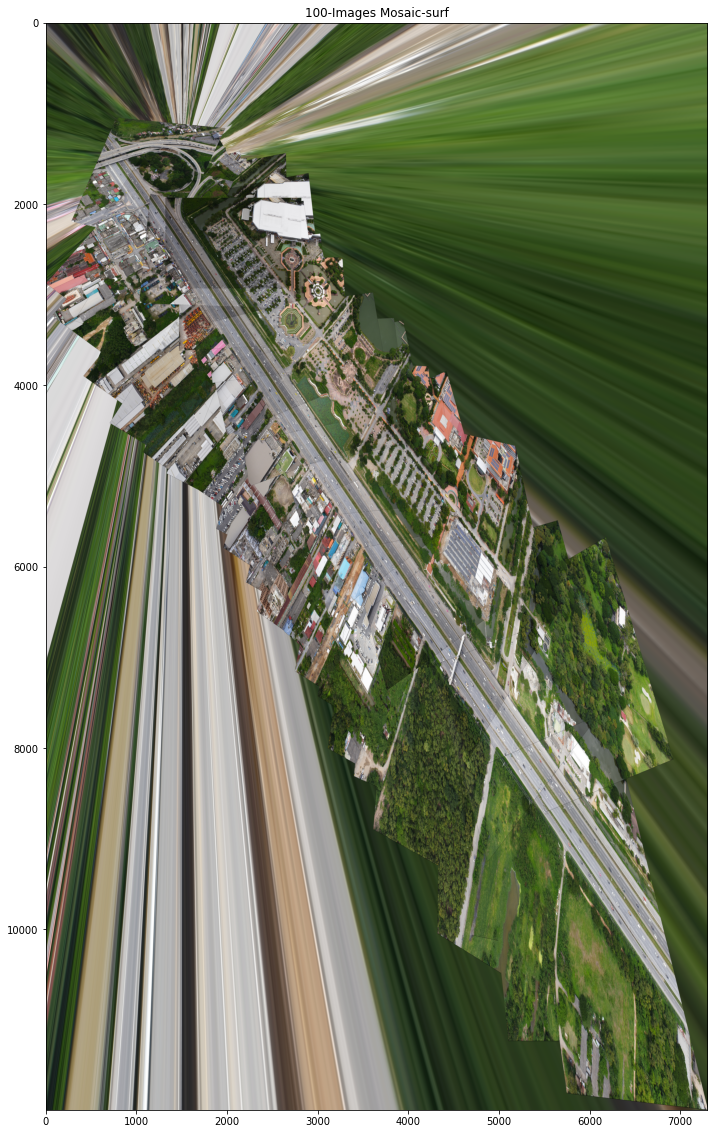

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_surf , cv2.COLOR_BGR2RGB))
ax.set_title('100-Images Mosaic-surf')